# Character Identification
In this notebook, I use Tfidf with several different machine learning models to perform classification of characters given a line of dialogue. Ultimately, SGDClassifier which uses SVC under the hood performs the best. I also try using word2vec, doc2vec, and keras to perform classification, but these methods do not really improve my model.

In [26]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

from gensim.models import Word2Vec
from itertools import islice

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

### Basic Preprocessing

In [2]:
with open("df","rb") as pickle_in:
    data = pickle.load(pickle_in)

In [3]:
df = data.rename(columns = {'line':'post','name':'tags'}).drop(columns='char_id')

In [4]:
df.head()

,post,tags
0,space pron seem to go on and on forever but th...,Fry
1,what the pron god pron be the future pron pare...,Fry
2,uh sort of what be with the eye cool an alien ...,Fry
3,pron god a million year yknow pron guess pron ...,Fry
4,delivery boy no not again please anything else...,Fry


In [5]:
my_tags = list(df.tags.unique())

In [6]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

%matplotlib inline

In [7]:
#Number of total words in scripts
df['post'].apply(lambda x: len(x.split(' '))).sum()

161966

In [8]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Modeling
Out of the various models I tried, SGDClassifier, stochastic gradient descent using support vector machines, performed the best. I tuned it using gridsearchCV as well.

In [9]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.29779837775202783
              precision    recall  f1-score   support

         Fry       0.00      0.00      0.00        50
      Bender       0.51      0.19      0.28       180
       Leela       1.00      0.01      0.02        93
  Farnsworth       0.28      0.97      0.43       221
    Zoidberg       0.00      0.00      0.00        42
         Amy       0.00      0.00      0.00        14
      Hermes       0.41      0.04      0.07       177
        Zapp       0.00      0.00      0.00        31
         Kif       0.00      0.00      0.00        55

    accuracy                           0.30       863
   macro avg       0.24      0.13      0.09       863
weighted avg       0.37      0.30      0.18       863



/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5504055619930475
              precision    recall  f1-score   support

         Fry       0.47      0.14      0.22        50
      Bender       0.51      0.59      0.55       180
       Leela       0.67      0.73      0.70        93
  Farnsworth       0.51      0.63      0.57       221
    Zoidberg       0.80      0.38      0.52        42
         Amy       0.60      0.64      0.62        14
      Hermes       0.55      0.57      0.56       177
        Zapp       0.79      0.48      0.60        31
         Kif       0.46      0.24      0.31        55

    accuracy                           0.55       863
   macro avg       0.60      0.49      0.52       863
weighted avg       0.56      0.55      0.54       863



In [38]:
report = classification_report(y_test, y_pred,target_names=my_tags)

In [39]:
type(report)

str

In [35]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

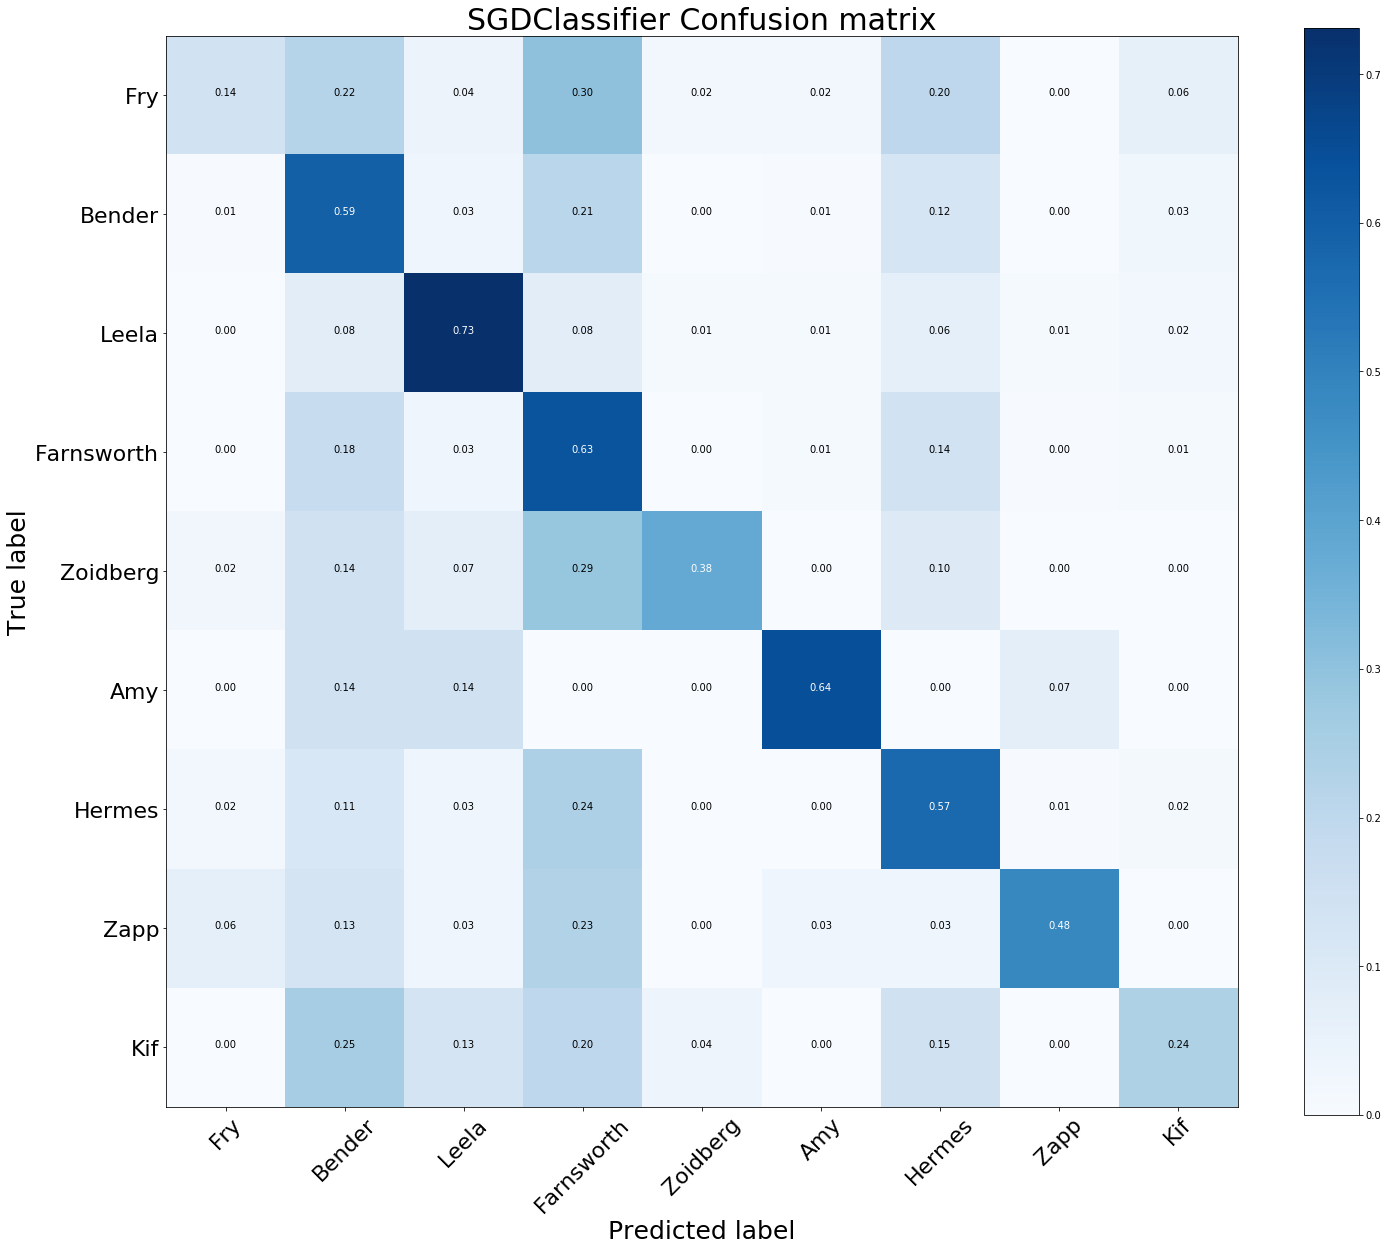

In [36]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=my_tags, title="SGDClassifier Confusion matrix")
plt.show()

SGD is my best classifier, so let's do some grid search.

In [19]:
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [30]:
sgd = SGDClassifier()

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}\n".format(score.parameters))
        
# Use a full grid over all parameters
param_grid = {"max_iter": [1, 5, 10],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              "penalty": ["none", "l1", "l2"]}

In [31]:
from time import time

# run grid search
grid_search = GridSearchCV(sgd, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X_tfidf, y)

/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [1, 5, 10],
                         'penalty': ['none', 'l1', 'l2']},
             pre_

In [32]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5040556199304751
              precision    recall  f1-score   support

         Fry       0.31      0.18      0.23        50
      Bender       0.48      0.48      0.48       180
       Leela       0.64      0.66      0.65        93
  Farnsworth       0.49      0.58      0.53       221
    Zoidberg       0.62      0.43      0.51        42
         Amy       0.60      0.64      0.62        14
      Hermes       0.48      0.54      0.51       177
        Zapp       0.65      0.42      0.51        31
         Kif       0.44      0.27      0.34        55

    accuracy                           0.50       863
   macro avg       0.52      0.47      0.49       863
weighted avg       0.50      0.50      0.50       863



In [42]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs',multi_class='auto')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5156431054461182
              precision    recall  f1-score   support

         Fry       0.27      0.18      0.22        50
      Bender       0.50      0.51      0.51       180
       Leela       0.64      0.75      0.69        93
  Farnsworth       0.52      0.57      0.54       221
    Zoidberg       0.52      0.36      0.42        42
         Amy       0.82      0.64      0.72        14
      Hermes       0.47      0.54      0.50       177
        Zapp       0.54      0.45      0.49        31
         Kif       0.55      0.29      0.38        55

    accuracy                           0.52       863
   macro avg       0.54      0.48      0.50       863
weighted avg       0.51      0.52      0.51       863



/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [51]:
xgb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(n_jobs=-1)),
               ])
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.4727694090382387
              precision    recall  f1-score   support

         Fry       0.50      0.14      0.22        50
      Bender       0.42      0.46      0.44       180
       Leela       0.67      0.48      0.56        93
  Farnsworth       0.42      0.62      0.50       221
    Zoidberg       0.69      0.26      0.38        42
         Amy       0.67      0.43      0.52        14
      Hermes       0.48      0.52      0.50       177
        Zapp       0.77      0.55      0.64        31
         Kif       0.59      0.18      0.28        55

    accuracy                           0.47       863
   macro avg       0.58      0.40      0.45       863
weighted avg       0.50      0.47      0.46       863



## Word2Vec

In [44]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [46]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [47]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/Users/isaackim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [49]:
logreg = LogisticRegression(n_jobs=1, C=1e5, solver = 'lbfgs', multi_class = 'auto')
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

accuracy 0.43337195828505215
              precision    recall  f1-score   support

         Fry       0.33      0.20      0.25        50
      Bender       0.42      0.48      0.45       180
       Leela       0.47      0.58      0.52        93
  Farnsworth       0.46      0.50      0.48       221
    Zoidberg       0.37      0.26      0.31        42
         Amy       0.21      0.29      0.24        14
      Hermes       0.49      0.42      0.45       177
        Zapp       0.42      0.32      0.36        31
         Kif       0.28      0.24      0.26        55

    accuracy                           0.43       863
   macro avg       0.38      0.37      0.37       863
weighted avg       0.43      0.43      0.43       863



/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [56]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [58]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2874/2874 [00:00<00:00, 2582354.26it/s]


In [59]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [64]:
logreg = LogisticRegression(n_jobs=-1, C=1e5, solver = 'lbfgs', multi_class = 'auto', max_iter = 10000)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.32560834298957125
              precision    recall  f1-score   support

         Fry       0.11      0.19      0.14        48
      Bender       0.43      0.31      0.36       189
       Leela       0.37      0.45      0.40       109
  Farnsworth       0.44      0.32      0.37       216
    Zoidberg       0.17      0.25      0.20        51
         Amy       0.32      0.33      0.32        18
      Hermes       0.36      0.33      0.34       149
        Zapp       0.33      0.36      0.35        33
         Kif       0.18      0.30      0.23        50

    accuracy                           0.33       863
   macro avg       0.30      0.32      0.30       863
weighted avg       0.36      0.33      0.33       863



## Keras 

In [66]:
X = df.post
y = df.tags
train_posts, test_posts, train_tags, test_tags = train_test_split(X, y, test_size=0.3, random_state = 42)

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 30

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1809 samples, validate on 202 samples
Epoch 1/30
1809/1809 [==============================] - 1s 380us/step - loss: 1.9128 - acc: 0.2803 - val_loss: 1.8617 - val_acc: 0.3119
Epoch 2/30
1809/1809 [==============================] - 0s 225us/step - loss: 1.4738 - acc: 0.5196 - val_loss: 1.6558 - val_acc: 0.4109
Epoch 3/30
1809/1809 [==============================] - 0s 218us/step - loss: 1.0998 - acc: 0.6656 - val_loss: 1.6213 - val_acc: 0.4257
Epoch 4/30
1809/1809 [==============================] - 0s 216us/step - loss: 0.8326 - acc: 0.7562 - val_loss: 1.5237 - val_acc: 0.4703
Epoch 5/30
1809/1809 [==============================] - 0s 222us/step - loss: 0.6197 - acc: 0.8375 - val_loss: 1.5476 - val_acc: 0.4604
Epoch 6/30
1809/1809 [==============================] - 0s 221us/step - loss: 0.4564 - acc: 0.8988 - val_loss: 1.6074 - val_acc: 0.4604
Epoch 7/30
1809/1809 [==============================] - 0s 223us/step - loss: 0.3522 - acc: 0.9281 - val_loss: 1.6512 - val_acc: 0.4703
E

In [67]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

863/863 [==============================] - 0s 39us/step
Test accuracy: 0.4669756659005498


In [68]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

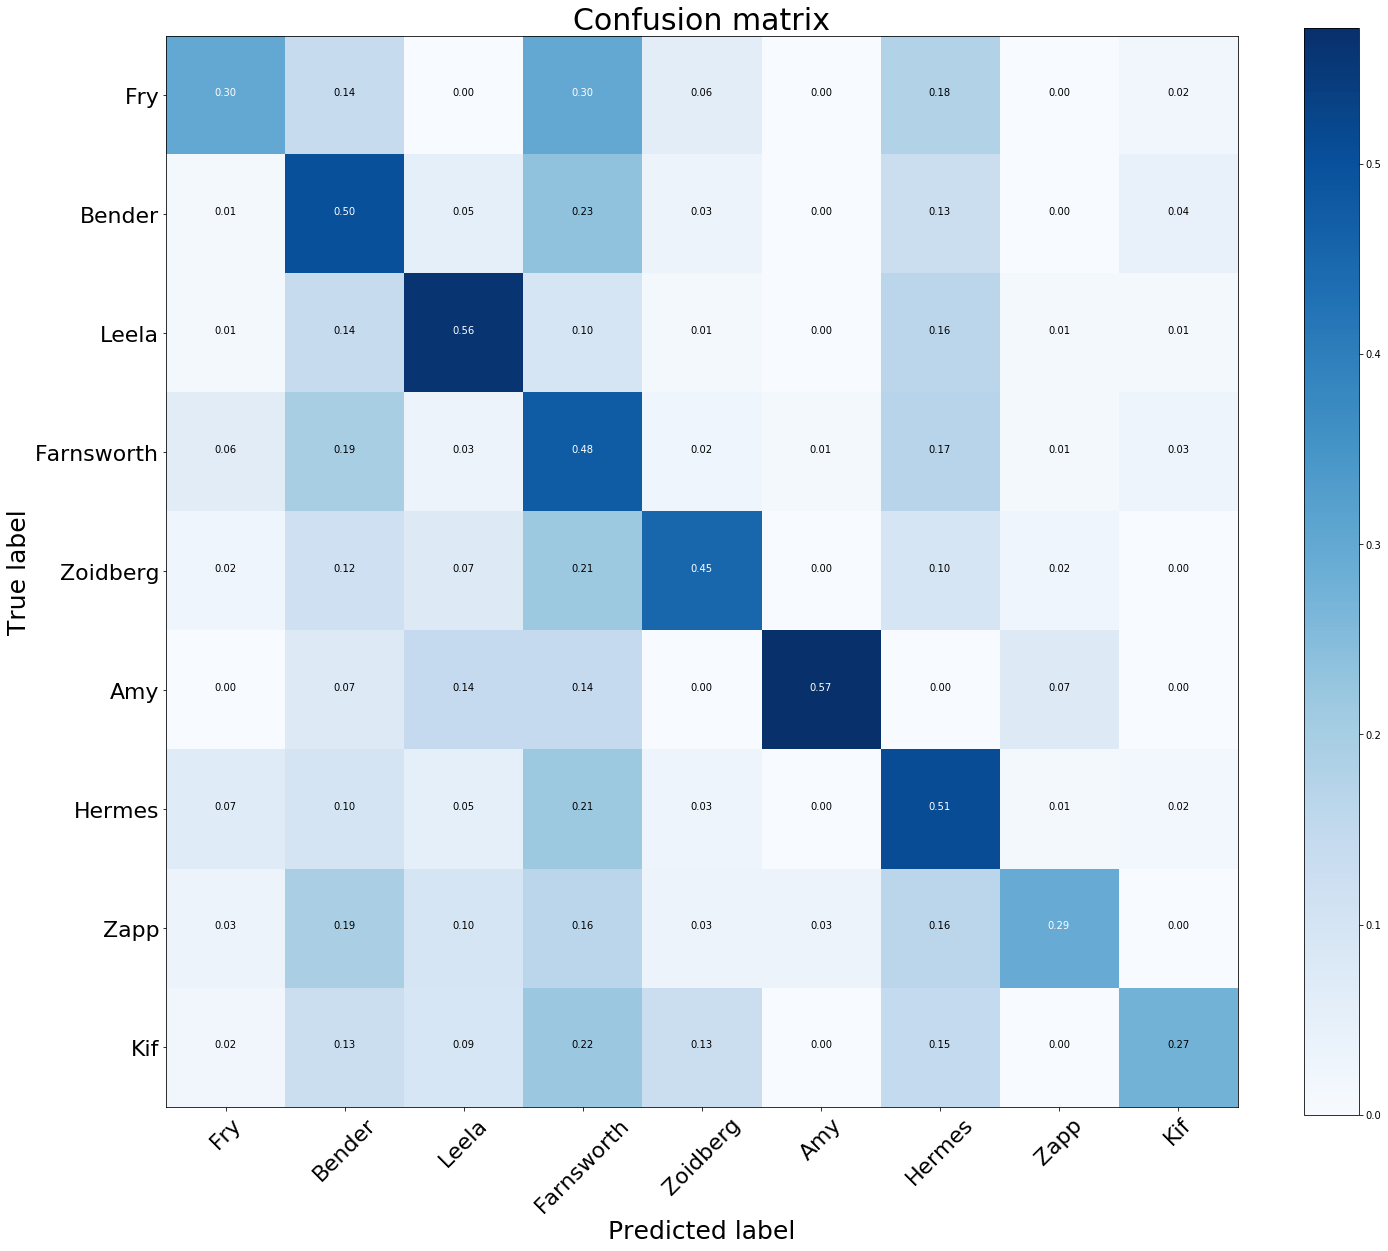

In [71]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=my_tags, title="Keras Model Confusion matrix")
plt.show()